<a href="https://colab.research.google.com/github/gautaman8/automatic_ticket_classification/blob/main/Automatic_Ticket_Classification_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [47]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [48]:
import os
files = os.listdir('/content/drive/MyDrive')
print(files)
file_loaded = {'complaints.json' in files}
print(f"\ncomplaints.json file loaded successfully? - {'complaints.json' in files} \n")

if file_loaded == False:
  print("Ensure file is present in your gdrive in the below path - MyDrive/complaints.json")


['001.JPG', 'DSC_0279.JPG', 'signature2014.jpg', 'DSC_0025-1.jpg', 'IMG_20130220_143617.jpg', '2013-02-25 16.37.37.jpg', '2013-02-25 16.37.46.jpg', 'DSC_0125.jpg', 'sarangan eb july 2016', 'Screenshot_20160924-221227.png', 'Screenshot_20160924-220634.png', 'Achievements in AQIRE.gdoc', 'Machine learning books', 'www.lassogear.com - Thank You.pdf', 'Private slides', 'Colab Notebooks', 'All This Time by Mikki Daughtry.epub', 'All This Time by Mikki Daughtry.mobi', 'NSW card.pdf', 'Convert old template to new template (Consider no html in questions).gscript', 'Resume', '1_Passport_Gautaman_Sarangan.pdf', 'degree certificate and marksheet.zip', '16_photo (1).jpg', 'VISA', '14 UG Consolidated Marksheet.pdf', '3_Degree_Certificate.pdf', '16_photo.jpg', 'To print', 'Statutory declaration - work experience.gdoc', 'MS', 'Cover Letter Template.docx', 'currencies.csv', 'odi-batting.csv', 'CustomerSurveyData.gsheet', 'DeliveryTimes DistanceData.gsheet', 'June 2014 Invoices.gsheet', 'Data Spreadshe

In [49]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [50]:
# Opening JSON file
file_path = '/content/drive/MyDrive/complaints.json'

with open(file_path, 'r') as f:
  data=json.load(f)
  df=pd.json_normalize(data)

# Normalized json data is loaded below
print(df.head())


                _index      _type      _id  _score   _source.tags  \
0  complaint-public-v2  complaint  3211475     0.0           None   
1  complaint-public-v2  complaint  3229299     0.0  Servicemember   
2  complaint-public-v2  complaint  3199379     0.0           None   
3  complaint-public-v2  complaint  2673060     0.0           None   
4  complaint-public-v2  complaint  3203545     0.0           None   

  _source.zip_code _source.complaint_id                       _source.issue  \
0            90301              3211475   Attempts to collect debt not owed   
1            319XX              3229299     Written notification about debt   
2            77069              3199379  Other features, terms, or problems   
3            48066              2673060      Trouble during payment process   
4            10473              3203545                    Fees or interest   

       _source.date_received _source.state  ... _source.company_response  \
0  2019-04-13T12:00:00-05:00      

## Data preparation

In [51]:
# Inspect the dataframe to understand the given data.
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [52]:
#print the column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [53]:
#Assign new column names
column_names_new = {col: col.lstrip('_').replace('.', '_') for col in df.columns}

df.rename(columns=column_names_new, inplace=True )
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   index                             78313 non-null  object 
 1   type                              78313 non-null  object 
 2   id                                78313 non-null  object 
 3   score                             78313 non-null  float64
 4   source_tags                       10900 non-null  object 
 5   source_zip_code                   71556 non-null  object 
 6   source_complaint_id               78313 non-null  object 
 7   source_issue                      78313 non-null  object 
 8   source_date_received              78313 non-null  object 
 9   source_state                      76322 non-null  object 
 10  source_consumer_disputed          78313 non-null  object 
 11  source_product                    78313 non-null  object 
 12  sour

In [54]:
#Assign nan in place of blanks in the complaints column

# source_tags cleaning
df.source_tags = df.source_tags.fillna('untagged')

In [55]:
# company_public_response
df[df['source_company_public_response'].notnull()]['source_company_public_response']
df.source_company_public_response = df.source_company_public_response.fillna('No response')

In [56]:
# source_zip_code cleaning
df.source_zip_code = df.source_zip_code.fillna('ZIP not recorded')


In [57]:
# sub_product cleaning
df.source_sub_product = df.source_sub_product.fillna('Sub product not available')

In [58]:
df[df['source_consumer_consent_provided'].notnull()]['source_consumer_consent_provided']
df.source_consumer_consent_provided = df.source_consumer_consent_provided.fillna('N/A')

In [59]:
df[df['source_sub_issue'].notnull()]['source_sub_issue']
df.source_sub_issue = df.source_sub_issue.fillna('Sub issue not available')

In [60]:
df[df['source_state'].notnull()]['source_state']
df.source_state = df.source_state.fillna('No state record available')

In [61]:
column_names_new = {col: col.replace('source_', '') for col in df.columns}

df.rename(columns=column_names_new, inplace=True )

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      78313 non-null  object 
 1   type                       78313 non-null  object 
 2   id                         78313 non-null  object 
 3   score                      78313 non-null  float64
 4   tags                       78313 non-null  object 
 5   zip_code                   78313 non-null  object 
 6   complaint_id               78313 non-null  object 
 7   issue                      78313 non-null  object 
 8   date_received              78313 non-null  object 
 9   state                      78313 non-null  object 
 10  consumer_disputed          78313 non-null  object 
 11  product                    78313 non-null  object 
 12  company_response           78313 non-null  object 
 13  company                    78313 non-null  obj

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,untagged,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,No response,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,No response,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,untagged,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,No response,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,untagged,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,No response,Conventional home mortgage,Yes,,Sub issue not available,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,untagged,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,No response,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


As seen above, all the data are now made non-null and cleaned.

#### Drop rows that're not relevant


In [62]:
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [63]:
# index
# type
# score
# tags
# zip_code
# complaint_id is same as id field, so it can be dropped too.
cols_to_drop = ["index", "type", "score", "tags", "zip_code", "complaint_id", "date_received", "state", "company", "submitted_via", "date_sent_to_company", "timely", "consumer_consent_provided"]

df = df.drop(columns = cols_to_drop)


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       78313 non-null  object
 1   issue                    78313 non-null  object
 2   consumer_disputed        78313 non-null  object
 3   product                  78313 non-null  object
 4   company_response         78313 non-null  object
 5   company_public_response  78313 non-null  object
 6   sub_product              78313 non-null  object
 7   complaint_what_happened  78313 non-null  object
 8   sub_issue                78313 non-null  object
dtypes: object(9)
memory usage: 5.4+ MB


In [67]:
df['consumer_disputed']=df['consumer_disputed'].replace("N/A", "not applicable")


In [66]:
# Convert to lowercase
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


In [68]:
df.head()

,id,issue,consumer_disputed,product,company_response,company_public_response,sub_product,complaint_what_happened,sub_issue
0,3211475,attempts to collect debt not owed,not applicable,debt collection,closed with explanation,no response,credit card debt,,debt is not yours
1,3229299,written notification about debt,not applicable,debt collection,closed with explanation,no response,credit card debt,good morning my name is xxxx xxxx and i apprec...,didn't receive enough information to verify debt
2,3199379,"other features, terms, or problems",not applicable,credit card or prepaid card,closed with explanation,no response,general-purpose credit card or charge card,i upgraded my xxxx xxxx card in xx/xx/2018 and...,problem with rewards from credit card
3,2673060,trouble during payment process,not applicable,mortgage,closed with explanation,no response,conventional home mortgage,,sub issue not available
4,3203545,fees or interest,not applicable,credit card or prepaid card,closed with explanation,no response,general-purpose credit card or charge card,,charged too much interest


In [80]:
df["complaint_what_happened"]=df["complaint_what_happened"].replace("","detailed complaint not available")
(df["complaint_what_happened"]=="").sum()

0

In [122]:
# Count zero above indicates that blank data is all removed for this field as well.
df.head()


,id,issue,product,company_response,company_public_response,sub_product,complaint_what_happened,sub_issue
0,3211475,attempts to collect debt not owed,debt collection,closed with explanation,no response,credit card debt,detailed complaint not available,debt is not yours
1,3229299,written notification about debt,debt collection,closed with explanation,no response,credit card debt,good morning my name is xxxx xxxx and i apprec...,didn't receive enough information to verify debt
2,3199379,"other features, terms, or problems",credit card or prepaid card,closed with explanation,no response,general-purpose credit card or charge card,i upgraded my xxxx xxxx card in xx/xx/2018 and...,problem with rewards from credit card
3,2673060,trouble during payment process,mortgage,closed with explanation,no response,conventional home mortgage,detailed complaint not available,sub issue not available
4,3203545,fees or interest,credit card or prepaid card,closed with explanation,no response,general-purpose credit card or charge card,detailed complaint not available,charged too much interest


In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       78313 non-null  object
 1   issue                    78313 non-null  object
 2   product                  78313 non-null  object
 3   company_response         78313 non-null  object
 4   company_public_response  78313 non-null  object
 5   sub_product              78313 non-null  object
 6   complaint_what_happened  78313 non-null  object
 7   sub_issue                78313 non-null  object
dtypes: object(8)
memory usage: 4.8+ MB


In [120]:
df = df.drop(columns = ['consumer_disputed'])

## Data preprocessing

In [89]:
!pip install nltk
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 16.1 MB/s eta 0:00:00


In [129]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import contractions

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

import re

def get_wordnet_pos(tag):
    if tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    elif tag.startswith('J'):
        return wordnet.ADJ
    else:
        return wordnet.NOUN

def preprocess_text(text):

    # expand text first
    text = contractions.fix(text)

    # remove punctuations
    text = re.sub(r'[^\w\s]', '', text)

    # remove text inside square brackets
    text = re.sub(r'\[.*?\]', '', text)

    # remove text containing numbers
    text = re.sub(r'\w*\d\w*', '', text)

    # remove xxxx
    text = text.replace('xxxx', ' ')

    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(token, get_wordnet_pos(pos_tag))
                         for token, pos_tag in tagged_tokens]
    lemmatized_text = ' '.join(lemmatized_text)
    nn_only = [lemmatizer.lemmatize(token)
                         for token, pos_tag in tagged_tokens if pos_tag.startswith('N')]
    nn_only = ' '.join(nn_only)

    return pd.Series({'complaint_lemmatized': lemmatized_text, 'complaint_pos_removed': nn_only})



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [117]:
# Example usage
text = "Tester of the lemma block, I'm [squared], ... ! xx/xx/92 xxxx"
processed_text = preprocess_text(text)
print(processed_text)



Tester of the lemma block I am squared     
complaint_lemmatized     Tester of the lemma block I be square
complaint_pos_removed                       Tester lemma block
dtype: object


In [126]:
df.columns

Index(['id', 'issue', 'product', 'company_response', 'company_public_response',
       'sub_product', 'complaint_what_happened', 'sub_issue'],
      dtype='object')

In [127]:
df_clean = pd.DataFrame()
df_clean['id'] = df["id"]


column_list = ['issue', 'product', 'sub_product', 'sub_issue', 'complaint_what_happened', 'company_response', 'company_public_response']

df_clean['raw_complaint'] = df[column_list].apply(lambda row: ' '.join(map(str, row)), axis=1)

print(df_clean)

            id                                      raw_complaint
0      3211475  attempts to collect debt not owed debt collect...
1      3229299  written notification about debt debt collectio...
2      3199379  other features, terms, or problems credit card...
3      2673060  trouble during payment process mortgage conven...
4      3203545  fees or interest credit card or prepaid card g...
...        ...                                                ...
78308  3105617  closing an account checking or savings account...
78309  3091984  other features, terms, or problems credit card...
78310  3133355  problem with a lender or other company chargin...
78311  3110963  other features, terms, or problems credit card...
78312  2001189  payment to acct not credited payday loan sub p...

[78313 rows x 2 columns]


In [138]:
df_clean[['complaint_lemmatized', 'complaint_pos_removed']] = df_clean['raw_complaint'].apply(preprocess_text)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase  - **DONE**
* Remove text in square brackets **DONE**
* Remove punctuation - **DONE**
* Remove words containing numbers **DONE**
* Remove xxxx **DONE**


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts **DONE**
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"] - All nouns are included. **DONE**


In [139]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,id,raw_complaint,complaint_lemmatized,complaint_pos_removed
0,3211475,attempts to collect debt not owed debt collect...,attempt to collect debt not owe debt collectio...,attempt debt debt collection credit card debt ...
1,3229299,written notification about debt debt collectio...,write notification about debt debt collection ...,notification debt debt collection credit card ...
2,3199379,"other features, terms, or problems credit card...",other feature term or problem credit card or p...,feature term problem credit card card generalp...
3,2673060,trouble during payment process mortgage conven...,trouble during payment process mortgage conven...,trouble payment process mortgage home mortgage...
4,3203545,fees or interest credit card or prepaid card g...,fee or interest credit card or prepay card gen...,fee interest credit card card generalpurpose c...
...,...,...,...,...
78308,3105617,closing an account checking or savings account...,close an account checking or saving account ch...,account checking saving account fund account c...
78309,3091984,"other features, terms, or problems credit card...",other feature term or problem credit card or p...,feature term problem credit card card generalp...
78310,3133355,problem with a lender or other company chargin...,problem with a lender or other company charge ...,problem lender company account checking saving...
78311,3110963,"other features, terms, or problems credit card...",other feature term or problem credit card or p...,feature term problem credit card card generalp...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [154]:
# Write your code here to visualise the data according to the 'Complaint' character length

import seaborn as sns
import matplotlib.pyplot as plt
import copy

visual_df = copy.deepcopy(df_clean)




In [156]:
visual_df['raw_complaint_len'] = df_clean['raw_complaint'].apply(len)
visual_df['complaint_lemmatized_len'] = df_clean['complaint_lemmatized'].apply(len)
visual_df['complaint_pos_removed_len'] = df_clean['complaint_pos_removed'].apply(len)

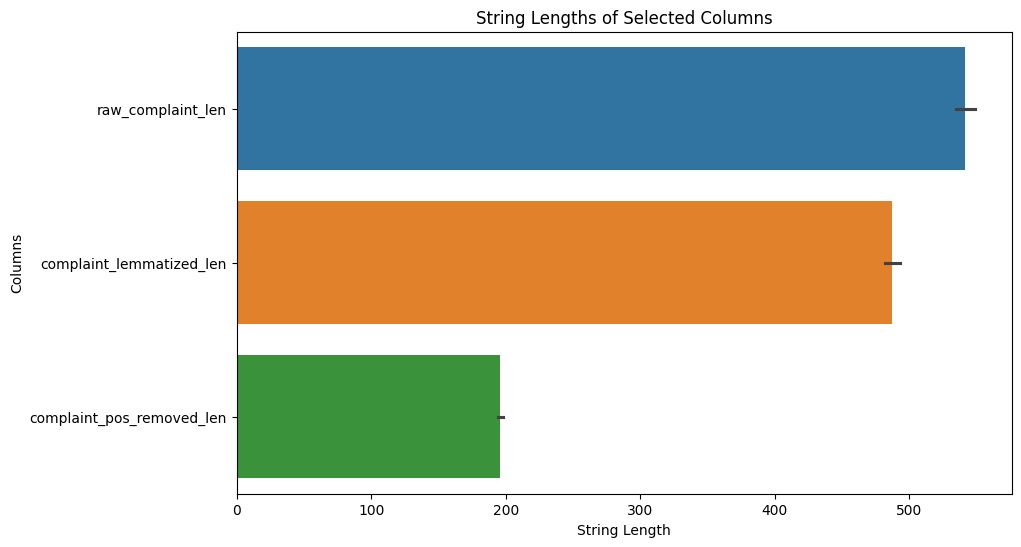

In [157]:
plt.figure(figsize = (10,6))
sns.barplot(data = visual_df, orient='h')
plt.title('String Lengths of Selected Columns')
plt.xlabel('String Length')
plt.ylabel('Columns')

plt.show()

In [160]:
melted_df = pd.melt(visual_df, value_vars=['raw_complaint_len', 'complaint_lemmatized_len', 'complaint_pos_removed_len' ])

In [161]:
melted_df

,variable,value
0,raw_complaint_len,153
1,raw_complaint_len,636
2,raw_complaint_len,535
3,raw_complaint_len,159
4,raw_complaint_len,182
...,...,...
234934,complaint_pos_removed_len,75
234935,complaint_pos_removed_len,776
234936,complaint_pos_removed_len,767
234937,complaint_pos_removed_len,616


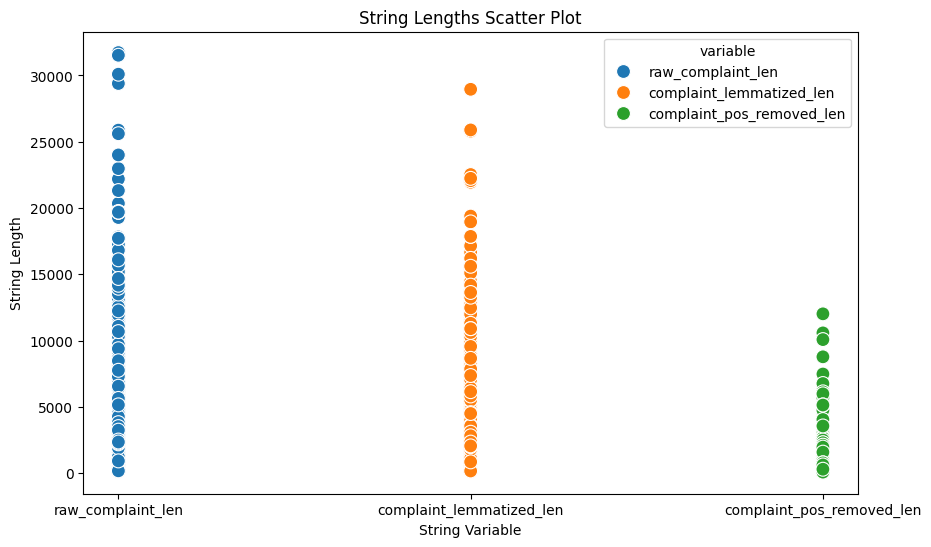

In [162]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=melted_df, x='variable', y='value', hue='variable', s=100)
plt.title('String Lengths Scatter Plot')
plt.xlabel('String Variable')
plt.ylabel('String Length')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

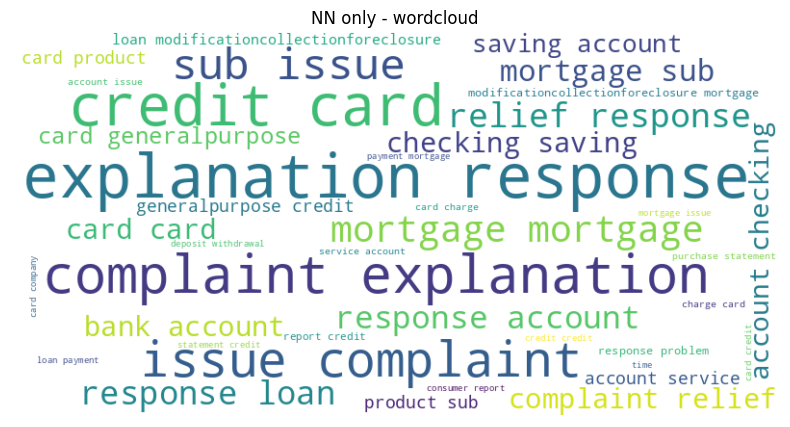

In [175]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud

text_data = ' '.join(df_clean['complaint_pos_removed'].astype(str).tolist())
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, max_words=40, background_color='white').generate(text_data)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.title('NN only - wordcloud')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

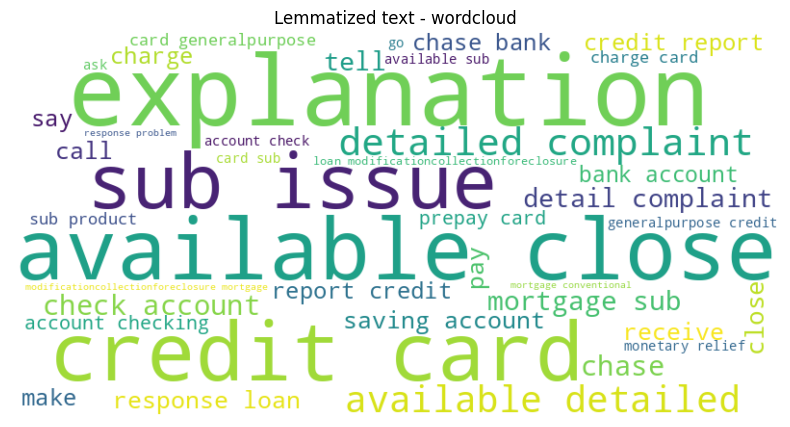

In [177]:
text_data = ' '.join(df_clean['complaint_lemmatized'].astype(str).tolist())
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, max_words=40, background_color='white').generate(text_data)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.title('Lemmatized text - wordcloud')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [191]:
df_clean = df_clean.drop(columns=['Complaint_clean'])

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

i: 140049
account: 97312
credit: 91059
card: 89899
response: 81155
complaint: 62300
explanation: 61454
mortgage: 57071
chase: 52072
issue: 52049
bank: 39893
loan: 35888
payment: 31065
sub: 29894
service: 25566
problem: 21191
charge: 18884
money: 17649
relief: 17614
report: 17425
time: 15972
information: 14972
saving: 14868
company: 14338
checking: 14096
day: 13265
product: 13022
statement: 12860
debt: 12737
fee: 12306


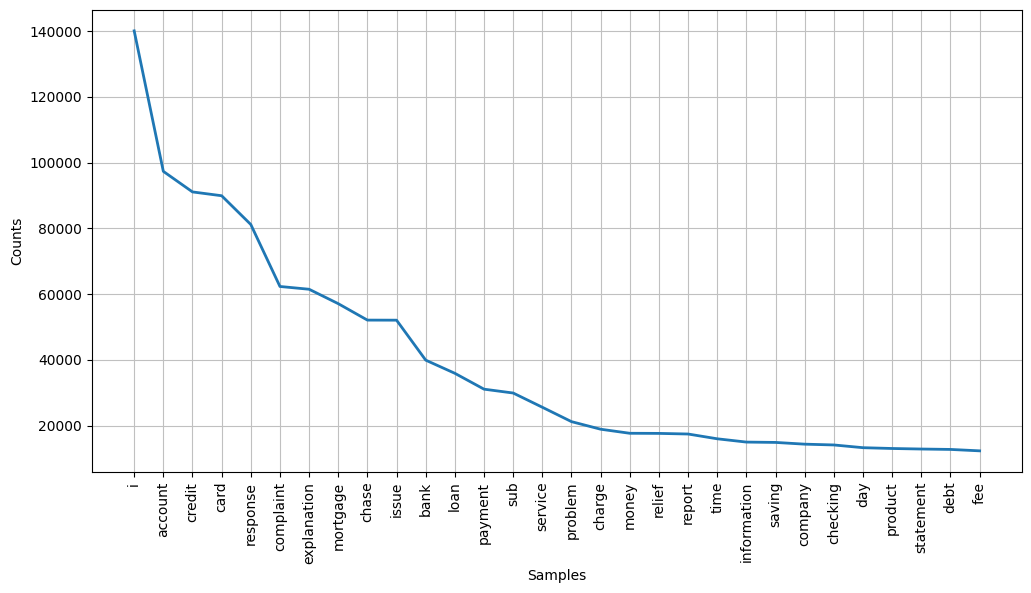

In [180]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
all_text = ' '.join(df_clean['complaint_pos_removed'].astype(str).tolist())

# Tokenize the text into words
words = word_tokenize(all_text)

# Calculate the frequency distribution of unigrams
freq_dist = FreqDist(words)

# Get the top 30 unigrams
top_30_unigrams = freq_dist.most_common(30)

for word, freq in top_30_unigrams:
  print(f'{word}: {freq}')

# Plot the top 30 unigrams
plt.figure(figsize=(12, 6))
freq_dist.plot(30, cumulative=False)
plt.show()

In [184]:
#Print the top 10 words in the unigram frequency
top_10_unigrams = freq_dist.most_common(10)

for word, freq in top_10_unigrams:
  print(f'{word}: {freq}')

i: 140049
account: 97312
credit: 91059
card: 89899
response: 81155
complaint: 62300
explanation: 61454
mortgage: 57071
chase: 52072
issue: 52049


('explanation', 'response'): 60231
('credit', 'card'): 51991
('complaint', 'explanation'): 44168
('issue', 'complaint'): 38329
('sub', 'issue'): 29879
('mortgage', 'mortgage'): 21068
('relief', 'response'): 17332
('response', 'loan'): 16753
('response', 'account'): 15866
('mortgage', 'sub'): 14211
('bank', 'account'): 12624
('complaint', 'relief'): 12524
('checking', 'saving'): 12437
('card', 'card'): 12366
('account', 'checking'): 11453
('saving', 'account'): 10616
('card', 'generalpurpose'): 10583
('generalpurpose', 'credit'): 10504
('card', 'product'): 10425
('product', 'sub'): 10379
('account', 'service'): 9893
('loan', 'modificationcollectionforeclosure'): 9743
('modificationcollectionforeclosure', 'mortgage'): 9743
('response', 'problem'): 9512
('i', 'i'): 9418
('report', 'credit'): 8493
('i', 'chase'): 8200
('account', 'i'): 7789
('service', 'account'): 7390
('account', 'issue'): 7329


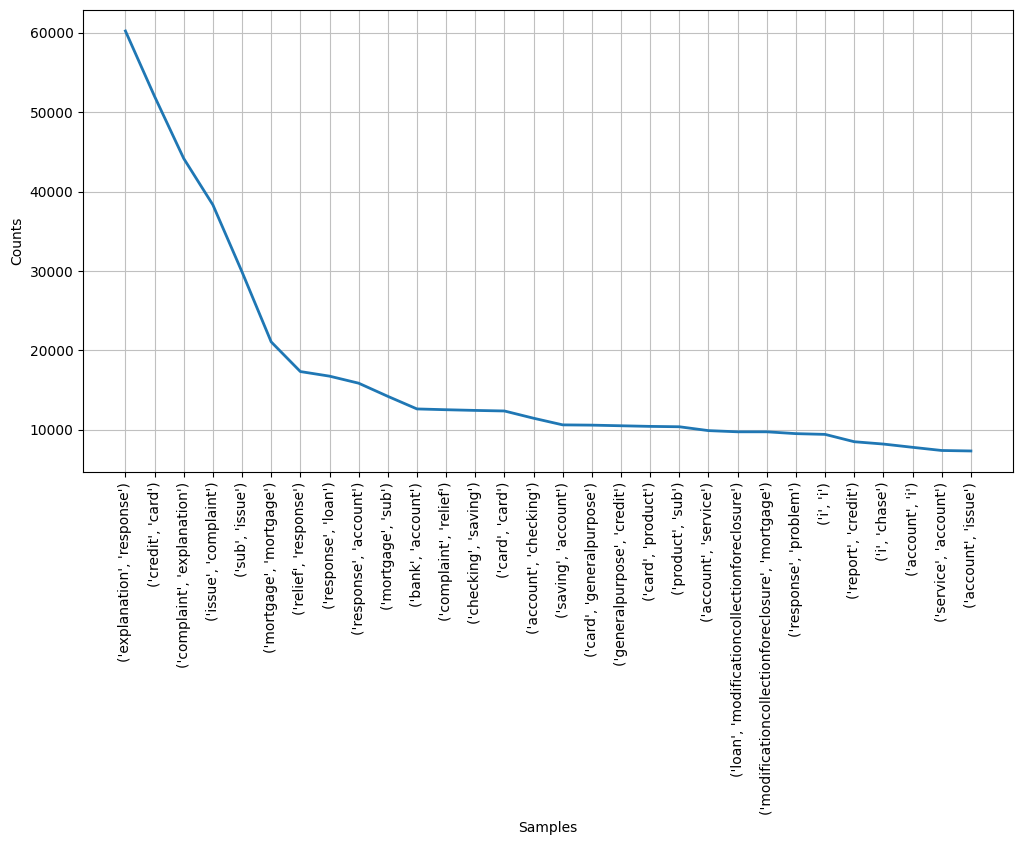

In [187]:

#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
from nltk.util import ngrams
bi_grams = list(ngrams(words,2))

# Calculate the frequency distribution of bigrams
freq_dist = FreqDist(bi_grams)

# Get the top 30 bigrams
top_30_bigrams = freq_dist.most_common(30)

# Display the top 30 bigrams and their frequencies
for bigram, freq in top_30_bigrams:
    print(f'{bigram}: {freq}')

# Plot the top 30 bigrams
plt.figure(figsize=(12, 6))
freq_dist.plot(30, cumulative=False)
plt.show()

('complaint', 'explanation', 'response'): 44163
('issue', 'complaint', 'explanation'): 29546
('sub', 'issue', 'complaint'): 25762
('mortgage', 'sub', 'issue'): 14211
('mortgage', 'mortgage', 'sub'): 13416
('explanation', 'response', 'loan'): 12990
('complaint', 'relief', 'response'): 12522
('explanation', 'response', 'account'): 12098
('credit', 'card', 'card'): 11450
('account', 'checking', 'saving'): 11359
('card', 'card', 'generalpurpose'): 10583
('card', 'generalpurpose', 'credit'): 10504
('generalpurpose', 'credit', 'card'): 10504
('credit', 'card', 'product'): 10409
('product', 'sub', 'issue'): 10379
('card', 'product', 'sub'): 10373
('response', 'account', 'checking'): 10159
('checking', 'saving', 'account'): 10152
('bank', 'account', 'service'): 9818
('response', 'loan', 'modificationcollectionforeclosure'): 9743
('loan', 'modificationcollectionforeclosure', 'mortgage'): 9743
('modificationcollectionforeclosure', 'mortgage', 'mortgage'): 9266
('issue', 'complaint', 'relief'): 8

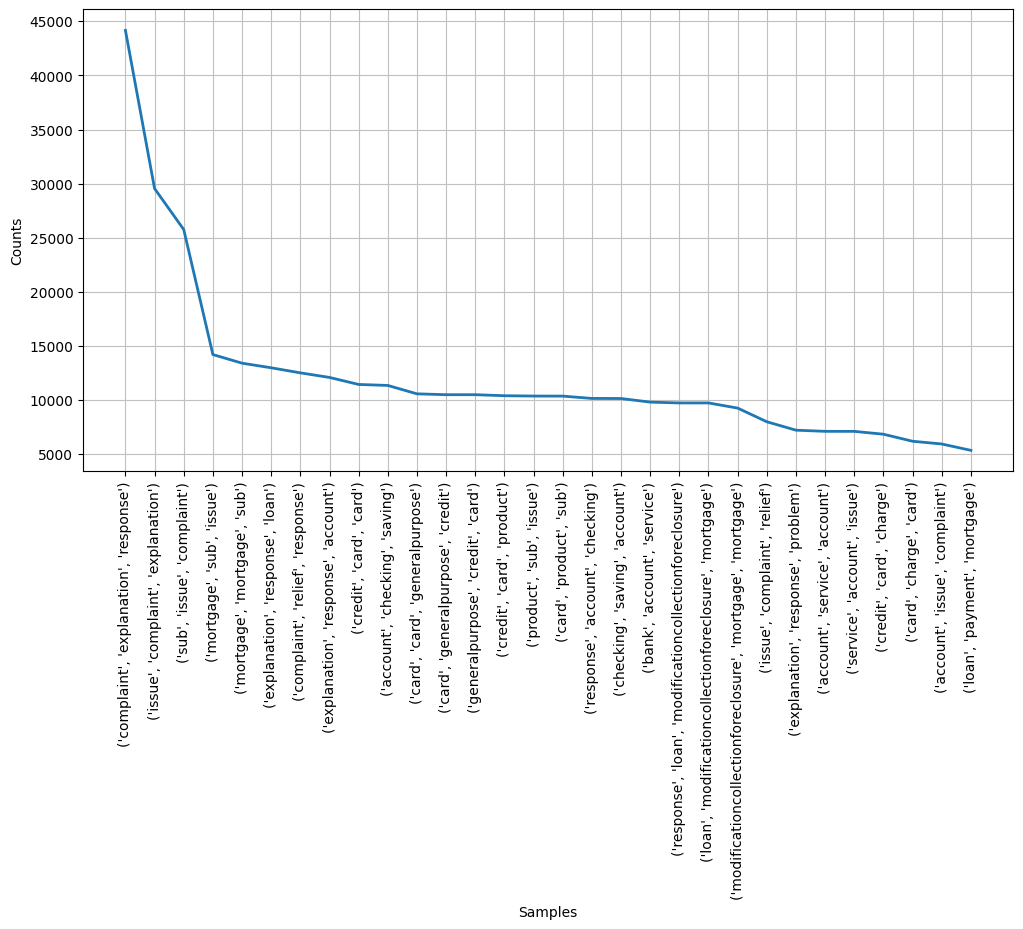

In [188]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).


#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
from nltk.util import ngrams
bi_grams = list(ngrams(words,3))

# Calculate the frequency distribution of bigrams
freq_dist = FreqDist(bi_grams)

# Get the top 30 bigrams
top_30_bigrams = freq_dist.most_common(30)

# Display the top 30 bigrams and their frequencies
for bigram, freq in top_30_bigrams:
    print(f'{bigram}: {freq}')

# Plot the top 30 bigrams
plt.figure(figsize=(12, 6))
freq_dist.plot(30, cumulative=False)
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [192]:

df_clean

,id,raw_complaint,complaint_lemmatized,complaint_pos_removed
0,3211475,attempts to collect debt not owed debt collect...,attempt to collect debt not owe debt collectio...,attempt debt debt collection credit card debt ...
1,3229299,written notification about debt debt collectio...,write notification about debt debt collection ...,notification debt debt collection credit card ...
2,3199379,"other features, terms, or problems credit card...",other feature term or problem credit card or p...,feature term problem credit card card generalp...
3,2673060,trouble during payment process mortgage conven...,trouble during payment process mortgage conven...,trouble payment process mortgage home mortgage...
4,3203545,fees or interest credit card or prepaid card g...,fee or interest credit card or prepay card gen...,fee interest credit card card generalpurpose c...
...,...,...,...,...
78308,3105617,closing an account checking or savings account...,close an account checking or saving account ch...,account checking saving account fund account c...
78309,3091984,"other features, terms, or problems credit card...",other feature term or problem credit card or p...,feature term problem credit card card generalp...
78310,3133355,problem with a lender or other company chargin...,problem with a lender or other company charge ...,problem lender company account checking saving...
78311,3110963,"other features, terms, or problems credit card...",other feature term or problem credit card or p...,feature term problem credit card card generalp...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [264]:
#Write your code here to initialise the TfidfVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming df_clean is your DataFrame
corpus = df_clean['complaint_pos_removed']  # Use the lemmatized column for TF-IDF

# Initialize TfidfVectorizer with max_df and min_df parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=25000)

# Fit and transform the corpus
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

# The resulting tfidf_matrix is a sparse matrix containing TF-IDF features
# You can convert it to a dense array if needed: tfidf_matrix.toarray()

# You can also get feature names (terms) corresponding to the columns
feature_names = tfidf_vectorizer.get_feature_names_out()

# Now, tfidf_matrix and feature_names can be used for further analysis or modeling


In [265]:
print(feature_names)
print(len(feature_names))

['account' 'card' 'complaint' 'credit' 'explanation' 'issue' 'sub']
7


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [266]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

from scipy.sparse import coo_matrix

# Convert the sparse matrix to coordinate format
coo_matrix = coo_matrix(tfidf_matrix)

# Get complaint_ids
complaint_ids = df_clean['id'].tolist()

# Create tuples (complaint_id, token_id, tf-idf score)
document_term_matrix = [(complaint_ids[i], j, tfidf_matrix[i, j]) for i, j in zip(coo_matrix.row, coo_matrix.col)]

# The document_term_matrix is a list of tuples
# Each tuple contains (complaint_id, token_id, tf-idf score)


In [267]:
document_term_matrix[:5]

[('3211475', 4, 0.3819459151647872),
 ('3211475', 2, 0.38233770457191224),
 ('3211475', 1, 0.6209716950761328),
 ('3211475', 3, 0.5677405670426314),
 ('3229299', 0, 0.5289573837858251)]

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters - **4 + One 'Others' cluster**
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [203]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [268]:
#Load your nmf_model with the n_components i.e 5
num_topics = 4 #write the value you want to test out
# 5th topic is other, whatever doesn't fit into 4 topics get classified as other

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [269]:
dtm = document_term_matrix
tfidf = tfidf_vectorizer
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

7

In [270]:
#Print the Top15 words for each of the topics
nmf_components = nmf_model.components_

# Define the number of top words to print for each topic
top_words_count = 15

# Print the top words for each topic
for topic_idx, topic in enumerate(nmf_components):
    top_words_idx = topic.argsort()[-top_words_count:][::-1]
    top_words = [feature_names[i] for i in top_words_idx]

    print(f"\nTop words for Topic {topic_idx + 1}:")
    print(top_words)


Top words for Topic 1:
['account', 'complaint', 'card']

Top words for Topic 2:
['account', 'complaint', 'card']

Top words for Topic 3:
['account', 'card', 'complaint']

Top words for Topic 4:
['account', 'card', 'complaint']


In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4



In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = #write your code to assign topics to each rows.

In [ ]:
df_clean.head()

In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=

In [ ]:
training_data

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics



